In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.__version__

'2.4.1+cu121'

## data preparing and loading

#### linear regresion 

In [3]:
weight = 0.7
bias = 0.3

start =0
end = 1
step = 0.02
x = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * x + bias

x[:10],y[:10], len(x), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [4]:
import pandas as pd
data = {
    'x': x.squeeze(),
    "y":y.squeeze()
}
df = pd.DataFrame(data)
df.head()

,x,y
0,0.00,0.300
1,0.02,0.314
2,0.04,0.328
3,0.06,0.342
4,0.08,0.356


train, test split

In [5]:
train_split = int(0.8*len(x))
xtrain,ytrain = x[:train_split],y[:train_split]
xtest,ytest = x[train_split:],y[train_split:]


len(xtrain),len(ytrain),len(xtest),len(ytest)

(40, 40, 10, 10)

In [6]:
def plot_predictions(
    train_data=xtrain,
    train_labels=ytrain,
    test_data=xtest,
    test_labels=ytest,
    predictions=None,
):
    """
    plot training data, test data and compares predictions.
    """

    plt.figure(figsize=(5,3))
    plt.scatter(train_data, train_labels, c="b", s=4, label="training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

    plt.legend(prop={"size": 10})

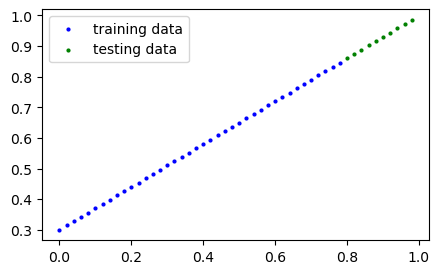

In [7]:
plot_predictions()

In [8]:
# model building
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [9]:
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.0684], requires_grad=True),
 Parameter containing:
 tensor([0.6232], requires_grad=True)]

In [10]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.0684])), ('bias', tensor([0.6232]))])

In [11]:
with torch.inference_mode():
    ypred = model_0(xtest)
    
ypred

tensor([[0.6779],
        [0.6793],
        [0.6806],
        [0.6820],
        [0.6834],
        [0.6847],
        [0.6861],
        [0.6875],
        [0.6889],
        [0.6902]])

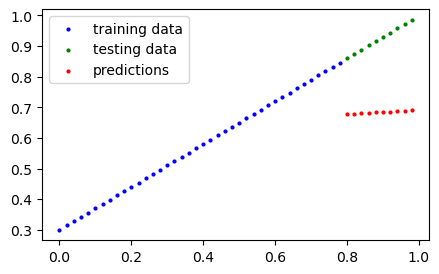

In [12]:
plot_predictions(predictions=ypred)

In [13]:
ypreds = model_0(xtest)
ypreds

tensor([[0.6779],
        [0.6793],
        [0.6806],
        [0.6820],
        [0.6834],
        [0.6847],
        [0.6861],
        [0.6875],
        [0.6889],
        [0.6902]], grad_fn=<AddBackward0>)

#### this one gives grad function , so infrence mode doesnot track the gradient, which doesnt store the unnecessary memory

In [14]:
with torch.no_grad():   #no grad doesnt track the gradient
    ypredss = model_0(xtest)
    
ypredss

tensor([[0.6779],
        [0.6793],
        [0.6806],
        [0.6820],
        [0.6834],
        [0.6847],
        [0.6861],
        [0.6875],
        [0.6889],
        [0.6902]])

* **Loss funtions** : loss functions measures how wrong the model's predictions are with the actual data
* **optimizers** : adjusts the models parameter


in pytorch: we need a training loop and a testing loop.

In [15]:
## seting up a loss funtion
loss_fn = nn.L1Loss() # L1 loss is mean absoluter loss 
#MAE_loss = torch.mean(torch.abs(ypred-ytest)) 

## setting up optimizers
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

### training and testing loop
0. loop thru the data
1. forward pass
2. calculate the loss 
3. optimize zero gradd
4. loss backward - move backward thru the network to calculate the gradient of each of the paramets of out model wtr the loss
5. optmizer step - use the optim to adjust the model param to try to minimize the loss

In [16]:
epochs = 10000  # loop once thru the data

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    # set the model to trainin mode
    model_0.train()  # sets the model to a state that require gradients for all the params

    # 1. Forward pass
    ytrain_pred = model_0(xtrain)

    # 2. Calculate the Loss
    train_loss = loss_fn(ytrain_pred,ytrain)

    # 3. Optimize zero gradd
    optimizer.zero_grad()
    
    # 4. Backpropagation / Loss backward
    train_loss.backward()
    
    # 5. Optimizer step
    optimizer.step()

    
    # set the model to testing mode
    model_0.eval()  # sets the model to a state that turns of gradient tracking
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(xtest)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred,ytest)
        
    if  epoch % 200 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Loss: {train_loss} | Test Loss: {test_loss}')

Epoch: 0 | Loss: 0.13800093531608582 | Test Loss: 0.2413560450077057
Epoch: 200 | Loss: 0.0625995546579361 | Test Loss: 0.1454509198665619
Epoch: 400 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 600 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 800 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 1000 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 1200 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 1400 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 1600 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 1800 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 2000 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 2200 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 2400 | Loss: 0.0039647407829761505 | Test Loss: 0.004851883742958307
Epoch: 2600 | Loss: 0.003964

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6907])), ('bias', tensor([0.2997]))])

In [18]:
weight,bias

(0.7, 0.3)

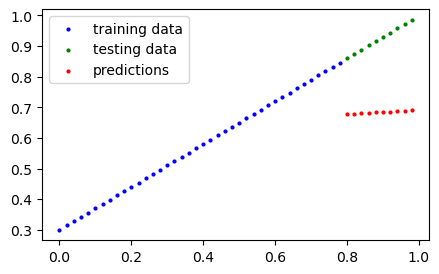

In [19]:
plot_predictions(predictions=ypred)

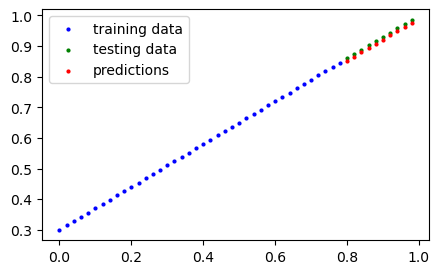

In [20]:
plot_predictions(predictions=test_pred)

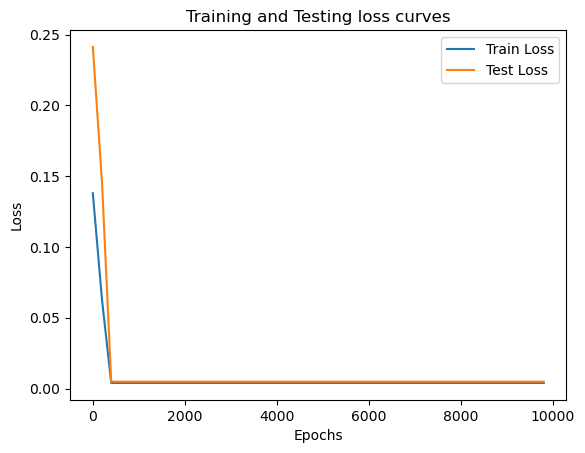

In [21]:
plt.plot(epoch_count,np.array(torch.tensor(train_loss_values).numpy()),label="Train Loss")
plt.plot(epoch_count,np.array(torch.tensor(test_loss_values).numpy()),label="Test Loss")
plt.title("Training and Testing loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

#### saving a model in pytorch

1. `torch.save()` -  saves in pickle format 
2. `torch.load()` - loads model
3. `torch.nn.Module.load_state_dict()`

In [24]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_LinearRegresssion_workflow.pth"

MODELS_SAVE_PATH = (
    MODEL_PATH / MODEL_NAME
)
print(f"Saving model to: {MODELS_SAVE_PATH}")

torch.save(obj=model_0.state_dict(), f=MODELS_SAVE_PATH)

Saving model to: models\01_pytorch_LinearRegresssion_workflow.pth


In [25]:
!ls -l models

total 4
-rw-r--r-- 1 rahul 197609 1740 Oct 16 11:10 01_pytorch_LinearRegresssion_workflow.pth


In [26]:
## loading pytorch models 
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=MODELS_SAVE_PATH))

C:\Users\rahul\AppData\Local\Temp\ipykernel_17072\3684975919.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODELS_SAVE_PATH))

<All keys matched successfully>

In [27]:
with torch.inference_mode():
    loaded_pred = loaded_model(xtest)
loaded_pred

tensor([[0.8522],
        [0.8660],
        [0.8798],
        [0.8937],
        [0.9075],
        [0.9213],
        [0.9351],
        [0.9489],
        [0.9627],
        [0.9765]])

In [28]:
test_pred == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

##  alternate method to create model

In [29]:
class LinearRegressionModelv2(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        # Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


model = LinearRegressionModelv2()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3124]])),
             ('linear_layer.bias', tensor([0.5811]))])

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [35]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [36]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01 )

In [37]:
epochs = 500
epoch_value=[]
train_loss_values = []
test_loss_values = []

# device agnostic device for data
xtrain = xtrain.to(device)
xtest = xtest.to(device)
ytrain = ytrain.to(device)
ytest = ytest.to(device)


for epoch in range(epochs):
    model.train()
    ytrain_pred = model(xtrain)
    train_loss = loss_fn(ytrain_pred,ytrain_pred)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        ypred = model(xtest)
    test_loss = loss_fn(ypred,ytest)
    
    
    if epoch % 50 == 0: 
        print(f'Epoch: {epoch} | Train Loss: {train_loss} | Test Loss {test_loss}')
        epoch_value.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

Epoch: 0 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 50 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 100 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 150 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 200 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 250 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 300 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 350 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 400 | Train Loss: 0.0 | Test Loss 0.06386388093233109
Epoch: 450 | Train Loss: 0.0 | Test Loss 0.06386388093233109


In [38]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3124]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.5811], device='cuda:0'))])

C:\Users\rahul\AppData\Local\Temp\ipykernel_17072\80958194.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_predictions(predictions=torch.tensor(ypred).cpu())


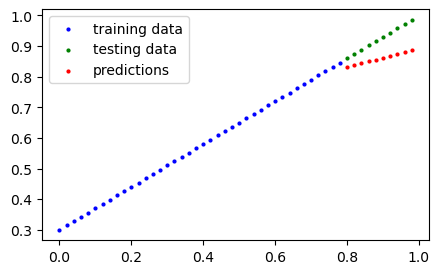

In [42]:
with torch.inference_mode():
    ypred = model(xtest)
plot_predictions(predictions=torch.tensor(ypred).cpu())